# Segmentation for multiclass population of objects

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm.auto import tqdm
from skimage.io import imsave, imread
import json
from scipy import ndimage as nd
import glob

In [29]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load images

In [3]:
# define experiment ID and select a position
expt = 'ND0022'
pos = 'Pos12'
# point to where the data is
root_dir = '/home/nathan/data/kraken/ras/'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
# lazily load images
images = DaskOctopusLiteLoader(image_path, 
                               remove_background = True)
images.channels

[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK_RFP: 97>,
 <Channels.MASK_GFP: 98>,
 <Channels.MASK: 99>]

Set segmentation channel and load test image

In [14]:
# set test image index
frame = 0
# load 2 single-channel test images 
gfp = images['gfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = gfp
img[:,:,1] = rfp
img.shape

reader.py (147): Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.


(1352, 1688, 2)

## 2. Load model and test segment single image 

In [2]:
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='../models')
model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.


StarDist2D(stardist_multiclass_MDCK): YXC → YXC
├─ Directory: /home/nathan/analysis/segment-classify-track/models/stardist_multiclass_MDCK
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=2, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=2, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 2], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2, 1], train_class_weights=[1, 1, 1], train_epochs=400, train_steps_per_epoch=100, train_learning_rat

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


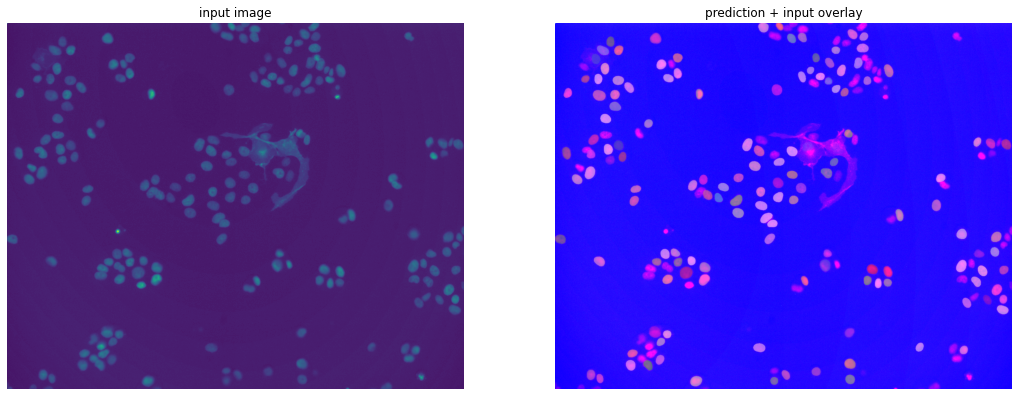

In [15]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]))
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

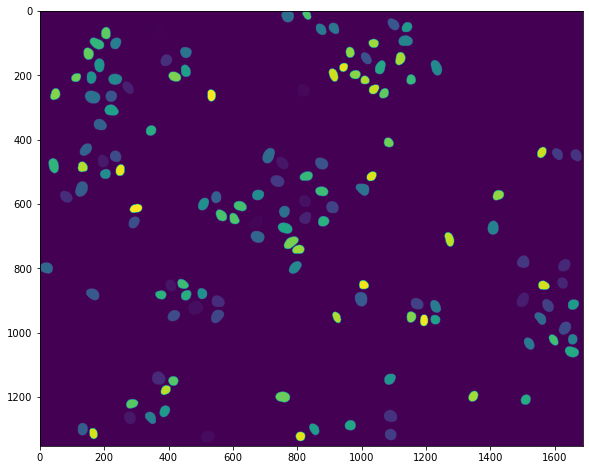

In [16]:
plt.imshow(labels)

### 2.2 Format mask so that it contains multiclass information 
(i.e. pixel value = class identity)

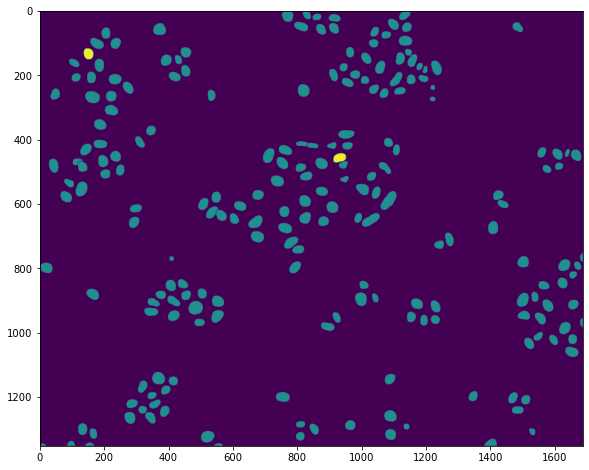

In [10]:
# format 2channel mask image 
mask = np.zeros(labels.shape)
# make multiclass mask from details dict
for cell_ID, class_label in enumerate(details['class_id'], 1):
    #needs erosion step to stop merging of labels
    segment = nd.binary_erosion(labels==cell_ID)
    mask[segment] = class_label
    # set background to zero
    mask[labels == 0] = 0
plt.imshow(mask)

## 3. Batch segment a whole stack of images

When you segment a whole data set you do not want to apply any image transformation. This is so that when you load images and masks later on you can apply the same transformation. You can apply a crop but note that you need to be consistent with your use of the crop from this point on, otherwise you'll get a shift. 

In [17]:
reference_channel = 'gfp'

In [19]:
%%time
for expt in tqdm(sorted(['ND0022'])):
    pos_list = ['Pos12']#sorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
#                         if 'Pos' in pos 
#                         and os.path.isdir(f'{root_dir}/{expt}/{pos}')],
#                         key = lambda x: [int(y) for y in re.findall(r'\d+', x)])
    for pos in tqdm(pos_list):

        print('Starting experiment position:', expt, pos)
        # load images
        image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
        images = DaskOctopusLiteLoader(image_path, 
                                       remove_background = True)

        # iterate over images filenames 
        for frame, fn in tqdm(enumerate(images.files(reference_channel)), 
                              position = 0, leave = True, total = len(images.files(reference_channel))):
#             if os.path.exists(((images.files('irfp')[frame])).replace('channel003', 'channel099')):
#                 continue
            # compile 2-channels into XYC array
            img = np.zeros((images[reference_channel][frame].shape[0], 
                            images[reference_channel][frame].shape[1], 2)) 
            img[:,:,0] = images['gfp'][frame]
            img[:,:,1] = images['rfp'][frame]
            # predict labels using 2ch image
            labels, details = model.predict_instances(normalize(img))
            # format 2channel mask image 
            mask = np.zeros(labels.shape)
            # make multiclass mask from details dict
            for cell_ID, class_label in enumerate(details['class_id'], 1):
                #needs erosion step to stop merging of labels
                segment = nd.binary_erosion(labels==cell_ID)
                mask[segment] = class_label
                # set background to zero
                mask[labels == 0] = 0
            # set filename as mask format (channel099)
            fn = ((images.files('gfp')[frame])).replace('channel001', 'channel099')
            # save out labelled image
            imsave(fn, mask.astype(np.uint8), check_contrast=False)
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Starting experiment position: ND0022 Pos12


  0%|          | 0/1106 [00:00<?, ?it/s]

CPU times: user 4h 37min 11s, sys: 36min 49s, total: 5h 14min 1s
Wall time: 2h 48min 6s


In [4]:
import glob
from natsort import natsorted
from skimage.io import imread
import os

In [6]:
gfp_ims = natsorted(glob.glob('/home/nathan/data/training_data/UNet_Training_Ras/all/gfp/*.tif'))


# iterate over images filenames 
for fn in tqdm(gfp_ims):
    # compile 2-channels into XYC array
    
    gfp = imread(fn)
    rfp = imread(fn.replace('gfp', 'rfp'))
    
    img = np.zeros((gfp.shape[0],gfp.shape[1], 2)) 
    img[:,:,0] = gfp
    img[:,:,1] = rfp
    # predict labels using 2ch image
    labels, details = model.predict_instances(normalize(img))#, prob_thresh=0.5)
    # format 2channel mask image 
    mask = np.zeros(labels.shape)
    # make multiclass mask from details dict
    for cell_ID, class_label in enumerate(details['class_id'], 1):
        #needs erosion step to stop merging of labels
        segment = nd.binary_erosion(labels==cell_ID)
        mask[segment] = class_label
        # set background to zero
        mask[labels == 0] = 0
    # set filename as mask format (channel099)
    fn = fn.replace('gfp', 'pred_ch99')
    
    if not os.path.exists(os.path.dirname(fn)):
        os.mkdir(os.path.dirname(fn))
    # save out labelled image
    imsave(fn, mask.astype(np.uint8), check_contrast=False)


  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
from skimage.io import imshow

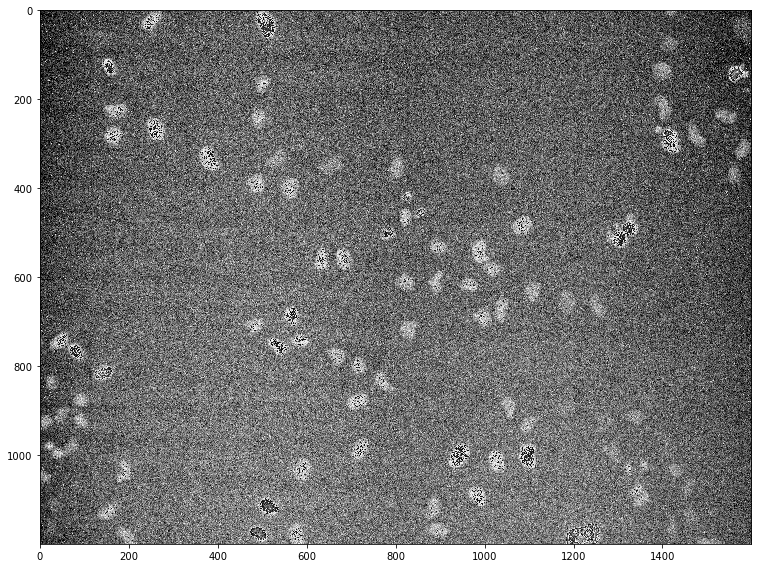

In [40]:
imshow(rfp*30)